Aim of this notebook is providing a simple pipeline for detecting HIV inhibitors using PyTorch and TorchGeometric.

# 1-Useful functions

In [1]:
import time
import sklearn
import matplotlib.pyplot as plt

In [2]:
def count_parameters(model):
  '''print number of parameters of a model'''
  
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])

  print("Number of Model's Parameters", params)

In [3]:
def history_plot(model_loss, model_metrics):
  '''plot learning curve for model's loss and metrics'''

  end_epoch = len(model_loss['training_loss'])

  fig, (ax1, ax2) = plt.subplots(1, 2)

  fig.set_figheight(6)
  fig.set_figwidth(12)

  ax1.plot(range(end_epoch), model_loss['training_loss'], color='forestgreen', label='Train')
  ax1.plot(range(end_epoch), model_loss['validation_loss'], color='lightcoral', label='Validation')
  ax1.set_xlabel('Epochs', fontsize=12)
  ax1.set_ylabel('Loss', fontsize=12)
  ax1.grid(True, ls='--')
  ax1.legend()

  ax2.plot(range(end_epoch), model_metrics['training_auc'], color='forestgreen', label='Train')
  ax2.plot(range(end_epoch), model_metrics['validation_auc'], color='lightcoral', label='Validation')
  ax2.set_xlabel('Epochs', fontsize=12)
  ax2.set_ylabel('AUC', fontsize=12)
  ax2.grid(True, ls='--')
  ax2.legend()

  
  plt.savefig('learning_curve.png', dpi=300)
  plt.show()

# 2-Installing and loading packages

In [4]:
#Installing useful package (Pytorch Geometric)

!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.6MB 4.7MB/s 
     |████████████████████████████████| 1.5MB 283kB/s 
     |████████████████████████████████| 215kB 5.9MB/s 
     |████████████████████████████████| 235kB 30.6MB/s 
     |████████████████████████████████| 2.2MB 26.5MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 


In [5]:
#Checking installed packages version

!python -c '''import torch; print("torch version:", torch.__version__)'''
!python -c '''import torch_geometric; print("torch geometric version:", torch_geometric.__version__)'''

torch version: 1.8.1+cu101
torch geometric version: 1.7.0


In [6]:
#Installing Rdkit (cheminformatics package)

import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format('3.7.0'),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))

install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


# 3-HIV potent drug classification

## 3-1 Dataset description

Description: 

The HIV dataset was introduced by the Drug Therapeutics Program (DTP) AIDS 
Antiviral Screen, which tested the ability to inhibit HIV replication for over 40 000 compounds ([Ref](https://wiki.nci.nih.gov/display/ncidtpdata/aids+antiviral+screen+data)) Screening results were evaluated and placed into three 
categories: confirmed inactive *(CI)*, confirmed active *(CA)* and confirmed moderately active (CM). We further combine the latter two labels, making it a classification task between inactive *(CI)* and active (*CA* and *CM*). As we are more interested in discover new categories of HIV inhibitors, scaffold splitting is recommended for this dataset.


---


```
Dataset   Datatype   Tasks              Compounds    Rec – split    Rec – metric
HIV       SMILES     Classification     41,913       Scaffold       ROC-AUC

*rec = recommended
```


---
The ROC curve (*receiver operating characteristic curve*) is created by plotting the **true positive rate** (*TPR*) against the **false positive rate** (*FPR*) at various threshold settings. The *area under the curve* (*AUC*) is area under ROC curve which is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one.Range of this metric is between 0 to 1. 

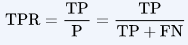

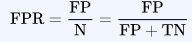

---



Scaffold splitting: 

Typical machine learning methods require datasets to be split into training/validation/test subsets  for benchmarking. HIV datasets is split into training, validation and test, following a 80/10/10 ratio.
*Random splitting* of molecular data isn't always best for evaluating machine learning methods. So Scaffold splitting is implemented to splits the samples based on their two-dimensional structural frameworks as implemented in **RDKit**.
*Scaffold splitting* attempts to separate structurally different molecules into different subsets, it offers a greater challenge for learning algorithms than the random split.

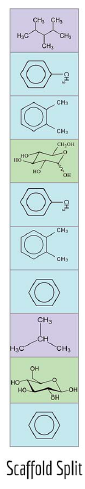 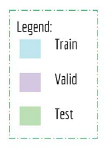


## 3-2 Loading data

The [MoleculeNet](https://arxiv.org/abs/1703.00564) benchmark collection, containing datasets from physical chemistry, biophysics and physiology. All datasets come with the additional node and edge features introduced by the [Open Graph Benchmark](https://https://ogb.stanford.edu/docs/graphprop/). Here, HIV dataset is chosen for analysis. All the molecules are pre-processed using **RDKit**. Each graph represents a molecule, where nodes are atoms, and edges are chemical bonds. Input node features are 9-dimensional, containing atomic number and chirality, as well as other additional atom features such as formal charge and whether the atom is in the ring or not. The full description of the features is as follow:


**Node features**: 

*possible_atomic_num_list* : (1, 2, ..., 119, misc)

*possible_chirality_list* : (CHI_UNSPECIFIED, CHI_TETRAHEDRAL_CW CHI_TETRAHEDRAL_CCW, CHI_OTHER)

*possible_degree_list* : (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, misc)

*possible_formal_charge_list* : (-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, misc)

*possible_numH_list* : (0, 1, 2, 3, 4, 5, 6, 7, 8, misc)

*possible_number_radical_e_list* : (0, 1, 2, 3, 4, misc)

*possible_hybridization_list* : (SP, SP2, SP3, SP3D, SP3D2, misc)

*possible_is_aromatic_list* : (False, True)

*possible_is_in_ring_list*: (False, True)

**Edge features**:

*possible_bond_type_list* : (SINGLE, DOUBLE, TRIPLE, AROMATIC, misc)

*possible_bond_stereo_list* : (STEREONONE, STEREOZ, STEREOE, STEREOCIS STEREOTRANS, STEREOANY)

*possible_is_conjugated_list*: (False, True)

In [7]:
from rdkit import Chem
from rdkit.Chem import Draw
from torch_geometric.datasets import MoleculeNet

In [8]:
dataset = MoleculeNet('/content/HIV/', 'HIV')

Processing...
Done!


In [9]:
#Dataset properties

print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

positive = 0
for item in dataset:
  positive += item.y
negative = len(dataset) - positive

print('Number of positive components:', int(positive.item()))
print('Number of negative components:', int(negative.item()))
print(f'Positive ratio: {(positive / len(dataset)).item() * 100:.3f} %')

#Checking first graph properties

data = dataset[0]

print()
print(data)
print('====================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: HIV(41127):
Number of graphs: 41127
Number of features: 9
Number of classes: 1
Number of positive components: 1443
Number of negative components: 39684
Positive ratio: 3.509 %

Data(edge_attr=[40, 3], edge_index=[2, 40], smiles="CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2", x=[19, 9], y=[1, 1])
Number of nodes: 19
Number of edges: 40
Average node degree: 2.11
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [10]:
def draw_2d(smile):
  '''draw 2d molecule structure from smile'''
   
  mol = Chem.MolFromSmiles(smile)
  fig = Draw.MolToMPL(mol, size=(150, 150))

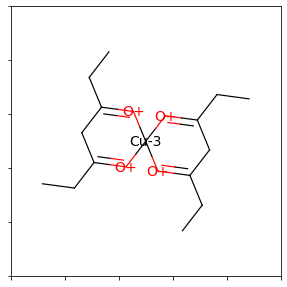

In [11]:
draw_2d(data.smiles)

## 3-3 Data splitting

Compute the *Bemis-Murcko* scaffold for a SMILES string.
*Bemis-Murcko* scaffolds are described in [Ref](https://pubs.acs.org/doi/10.1021/jm9602928). They are essentially that part of the molecule consisting of
rings and the linker atoms between them.

In [12]:
import numpy as np
from rdkit import Chem
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles

In [13]:
class SplitingDataset(object):

  """SplitingDataset splits up a given MoleculeNet dataset class into pieces for 
     training/validation/test sets based on scaffold or random methods."""

  def __init__(self, dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1):

    """
    Parameters

    ----------

    dataset: MoleculeNet dataset
      Dataset to be split.
    frac_train: float, optional(default 0.8)
      The fraction of the data to be used for the training split.
    frac_valid: float, optional (default 0.1)
      The fraction of the data to be used for validation split.
    frac_test: float, optional (default 0.1)
      The fraction of the data to be used for test split.

    """

    self.dataset = dataset
    self.frac_train = frac_train
    self.frac_valid = frac_valid
    self.frac_test = frac_test

  def _generate_scaffold(self, smile):

    """This is called by _generate_scaffold_sets to generate 
    scaffold for one smile"""

    mol = Chem.MolFromSmiles(smile)
    scaffold = MurckoScaffoldSmiles(mol=mol)
  
    return scaffold 

  def _generate_scaffold_sets(self, smiles):

    """This is called by scaffold_splitting to generate scaffold sets"""

    scaffolds = {}

    for ind, smile in enumerate(smiles):
      scaffold = self._generate_scaffold(smile)
      if scaffold not in scaffolds:
        scaffolds[scaffold] = [ind]
      else:
        scaffolds[scaffold].append(ind)

    scaffolds = {key: sorted(value) for key, value in scaffolds.items()}
    scaffold_sets =[scaffold_set for (scaffold, scaffold_set) in sorted(
                  scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True)]

    assert len(scaffolds) == len(scaffold_sets)

    print('Number of molecules: ', len(smiles))
    print('Number of scaffolds: ', len(scaffolds))
  
    return scaffold_sets

  def scaffold_splitting(self):

    """

    Splits molecules based on their scaffolds using Bemis-Murcko method in Rdkit
    package into train/validation/test sets.

    Returns

    -------
    MoleculeNet class, MoleculeNet class, MoleculeNet class,
    Train, validation and test sets respectively.

    """

    smiles = [self.dataset[item].smiles for item in range(len(self.dataset))]

    train_cutoff = self.frac_train * len(self.dataset)
    valid_cutoff = (self.frac_train + self.frac_valid) * len(self.dataset)

    train_inds = []
    valid_inds = []
    test_inds = []

    scaffold_sets = self._generate_scaffold_sets(smiles)

    for scaffold_set in scaffold_sets:
      if len(train_inds) + len(scaffold_set) > train_cutoff:
        if len(train_inds) + len(valid_inds) + len(scaffold_set) > valid_cutoff:
          test_inds += scaffold_set
        else:
          valid_inds += scaffold_set
      else:
        train_inds += scaffold_set
  
    assert len(train_inds) + len(valid_inds) + len(test_inds) == len(self.dataset)

    print('Train set size: ', len(train_inds))
    print('Validation set size: ', len(valid_inds))
    print('Test set size: ', len(test_inds))

    return self.dataset[train_inds], self.dataset[valid_inds], self.dataset[test_inds]

  def random_splitting(self):

    """

    Splits molecules randomly into train/validation/test sets.

    Returns

    -------
    MoleculeNet class, MoleculeNet class, MoleculeNet class,
    Train, validation and test sets respectively.

    """
  
    num_data = len(self.dataset)
    train_cutoff = int(self.frac_train * num_data)
    valid_cutoff = int((self.frac_train + self.frac_valid) * num_data)
    shuffled = np.random.permutation(range(num_data))

    train_inds = list(shuffled[:train_cutoff])
    valid_inds = list(shuffled[train_cutoff:valid_cutoff])
    test_inds = list(shuffled[valid_cutoff:])

    assert len(shuffled) == len(train_inds) + len(valid_inds) + len(test_inds)
  
    print('Number of molecules: ', num_data)
    print('Train set size: ', len(train_inds))
    print('Validation set size: ', len(valid_inds))
    print('Test set size: ', len(test_inds))

    return dataset[train_inds], dataset[valid_inds], dataset[test_inds]

In [14]:
split = SplitingDataset(dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1)
train_set, valid_set, test_set = split.scaffold_splitting()

Number of molecules:  41127
Number of scaffolds:  19089
Train set size:  32901
Validation set size:  4113
Test set size:  4113


# 4-GNN  

In this notebook, I've used GIN (graph isomorphism network) with and without edge properties as a training model. 

## GINe

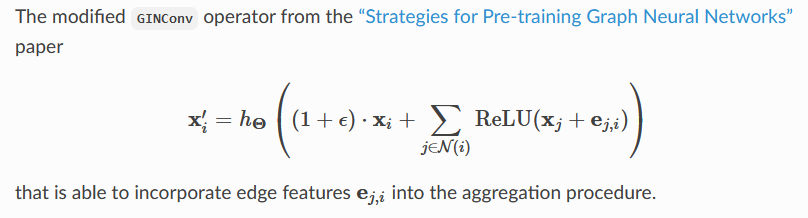

## GIN

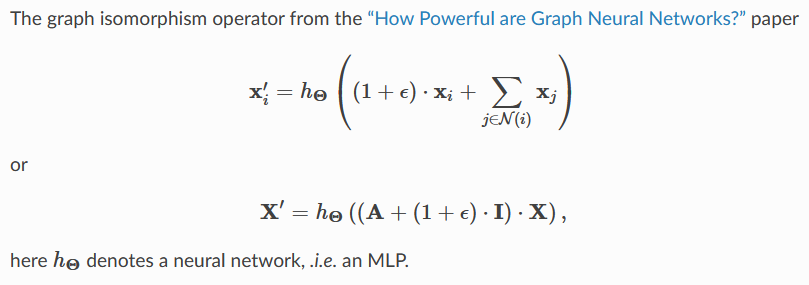

Ref papers:

[1 - How Powerful are Graph Neural Networks?](https://arxiv.org/abs/1810.00826)

[2 - Strategies for Pre-training Graph
Neural Networks](https://arxiv.org/abs1905.12265)

In [15]:
import torch
import torch.nn.functional as F
import torch_geometric

In [16]:
class GINe(torch.nn.Module):
  """building GIN model with the edge attributions and global add pooling"""
  
  def __init__(self, emb_dim):

    """
    Parameters

    ----------

    emb_dim: integer
     Dimension of embedding layer output

    """

    super(GINe, self).__init__()

    self.attentions = False

    self.emb_dim = emb_dim

    self.mlp1 = torch.nn.Sequential(torch.nn.Linear(emb_dim, 2 * emb_dim),
                                   torch.nn.BatchNorm1d(2 * emb_dim),
                                   torch.nn.ReLU(),
                                   torch.nn.Linear(2 * emb_dim, emb_dim))
    
    self.mlp2 = torch.nn.Sequential(torch.nn.Linear(emb_dim, 2 * emb_dim),
                                   torch.nn.BatchNorm1d(2 * emb_dim),
                                   torch.nn.ReLU(),
                                   torch.nn.Linear(2 * emb_dim, emb_dim))
    
    self.mlp3 = torch.nn.Sequential(torch.nn.Linear(emb_dim, 2 * emb_dim),
                                   torch.nn.BatchNorm1d(2 * emb_dim),
                                   torch.nn.ReLU(),
                                   torch.nn.Linear(2 * emb_dim, emb_dim))
    
    self.bond_encoder = BondEncoder(emb_dim = emb_dim)
    self.atom_encoder = AtomEncoder(emb_dim = emb_dim)

    self.gine1 = torch_geometric.nn.GINEConv(self.mlp1)
    self.gine2 = torch_geometric.nn.GINEConv(self.mlp2)
    self.gine3 = torch_geometric.nn.GINEConv(self.mlp3)

    self.fc1 = torch.nn.Linear(emb_dim, 100)
    self.fc2 = torch.nn.Linear(100, 50)
    self.fc3 = torch.nn.Linear(50, 1)

    self.batchnorm1 = torch.nn.BatchNorm1d(100, 100)
    self.batchnorm2 = torch.nn.BatchNorm1d(50, 50)

    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, atomic_input, bonding_input, edge_index, batch):

    """

    Forward phase of model

    Returns

    ---------------------

    Binary class

    """

    atomic_embedding = self.atom_encoder(atomic_input)
    bonding_embedding = self.bond_encoder(bonding_input)

    x = F.relu(self.gine1(atomic_embedding, edge_index, bonding_embedding))
    x = F.relu(self.gine2(x, edge_index, bonding_embedding))
    x = F.relu(self.gine3(x, edge_index, bonding_embedding))
    x = torch_geometric.nn.global_add_pool(x, batch)
    x = F.relu(self.batchnorm1(self.fc1(x)))
    x = F.dropout(x, p=0.3, training=self.training)
    x = F.relu(self.batchnorm2(self.fc2(x)))
    x = F.dropout(x, p=0.3, training=self.training)
    x = self.sigmoid(self.fc3(x))

    return x

    

# 5-Allowable range of features

In [17]:
import torch
import torch.nn.functional as F

In [18]:
#allowable range of molecule features

allowable_features = {
    'possible_atomic_num_list' : list(range(1, 119)) + ['misc'],
    'possible_chirality_list' : [
        'CHI_UNSPECIFIED',
        'CHI_TETRAHEDRAL_CW',
        'CHI_TETRAHEDRAL_CCW',
        'CHI_OTHER'
    ],
    'possible_degree_list' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'misc'],
    'possible_formal_charge_list' : [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 'misc'],
    'possible_numH_list' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 'misc'],
    'possible_number_radical_e_list': [0, 1, 2, 3, 4, 'misc'],
    'possible_hybridization_list' : [
        'SP', 'SP2', 'SP3', 'SP3D', 'SP3D2', 'misc', 'misc'
        ],
    'possible_is_aromatic_list': [False, True],
    'possible_is_in_ring_list': [False, True],
    'possible_bond_type_list' : [
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'AROMATIC',
        'misc'
    ],
    'possible_bond_stereo_list': [
        'STEREONONE',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
        'STEREOANY',
    ], 
    'possible_is_conjugated_list': [False, True],
}

In [19]:
def get_atom_feature_dims():
    """return dimension of each allowable atom features"""

    return list(map(len, [
        allowable_features['possible_atomic_num_list'],
        allowable_features['possible_chirality_list'],
        allowable_features['possible_degree_list'],
        allowable_features['possible_formal_charge_list'],
        allowable_features['possible_numH_list'],
        allowable_features['possible_number_radical_e_list'],
        allowable_features['possible_hybridization_list'],
        allowable_features['possible_is_aromatic_list'],
        allowable_features['possible_is_in_ring_list']
        ]))
    
def get_bond_feature_dims():
    """return dimension of each allowable bond features"""
    
    return list(map(len, [
        allowable_features['possible_bond_type_list'],
        allowable_features['possible_bond_stereo_list'],
        allowable_features['possible_is_conjugated_list']
        ]))

In [20]:
class AtomEncoder(torch.nn.Module):
    """Embedding layer for atomic features"""

    def __init__(self, emb_dim):

        """
        Parameters

        ----------

        emb_dim: integer
        Dimension of embedding layer output

         """
        super(AtomEncoder, self).__init__()
        
        self.atom_embedding_list = torch.nn.ModuleList()

        for i, dim in enumerate(full_atom_feature_dims):
            emb = torch.nn.Embedding(dim, emb_dim)
            torch.nn.init.xavier_uniform_(emb.weight.data)
            self.atom_embedding_list.append(emb)

    def forward(self, x):

        """

        Return

        -----

        Atomic embedding

        """

        x_embedding = 0
        for i in range(x.shape[1]):
            x_embedding += self.atom_embedding_list[i](x[:,i])

        return x_embedding


class BondEncoder(torch.nn.Module):
    """Embedding layer for bonding features"""
    
    def __init__(self, emb_dim):

        """
        Parameters

        ----------

        emb_dim: integer
        Dimension of embedding layer output

         """
        super(BondEncoder, self).__init__()
        
        self.bond_embedding_list = torch.nn.ModuleList()

        for i, dim in enumerate(full_bond_feature_dims):
            emb = torch.nn.Embedding(dim, emb_dim)
            torch.nn.init.xavier_uniform_(emb.weight.data)
            self.bond_embedding_list.append(emb)

    def forward(self, edge_attr):

        """

        Return

        -----

        Bonding embedding

        """
        
        bond_embedding = 0
        for i in range(edge_attr.shape[1]):
            bond_embedding += self.bond_embedding_list[i](edge_attr[:,i])

        return bond_embedding

In [21]:
full_atom_feature_dims = get_atom_feature_dims()
full_bond_feature_dims = get_bond_feature_dims()

# 6-Training and validating functions

In [22]:
from torch_geometric.data import DataLoader

In [23]:
class EarlyStopping(object):
    
    """Early stopping implementation"""
    
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
      
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)
        self.best_epoch = None 

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics, model, path, epoch):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
            self.best_epoch = epoch
            torch.save(model.state_dict(), path)
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [24]:
def train(epoch, model, device, train_loader, optimizer, criterion):

  """

  Parameters

  epoch: integer
    Epoch

  model: object
    Instance of model class

  device: 'cpu' or 'cuda'
    torch.device()
  
  train_loader: object
    torch_geometric.data.DataLoader() object

  optimizer: object
    torch.optim.Adam() object
  
  criterion: object
    Loss function

  
  Returns

  --------------

  Mean loss, Accuracy, AUC

  """

  
  model.train()
  loss_all = 0
  correct_all = 0
  preds_all = []
  labels_all = []

  for data in train_loader:

    data = data.to(device)
    optimizer.zero_grad()
    outputs = model(data.x, data.edge_attr, data.edge_index, data.batch)
      
    loss = criterion(outputs, data.y)
    loss.backward()
    loss_all += loss.item() * data.num_graphs
    preds_all.append(outputs.round().squeeze().detach().cpu().numpy())
    labels_all.append(data.y.squeeze().detach().cpu().numpy())
    correct_all += (outputs.round() == data.y).sum().cpu().float().item()
    optimizer.step()

  targets = [item for sublist in labels_all for item in sublist]
  predictions = [item for sublist in preds_all for item in sublist]

  fpr, tpr, thresholds = sklearn.metrics.roc_curve(targets, predictions)
  auc = sklearn.metrics.auc(fpr, tpr)

  return loss_all / len(train_set), correct_all / len(train_set), auc


In [25]:
def check(model, device, loader, criterion):

  """

  Parameters

  model: object
    Instance of model class

  device: 'cpu' or 'cuda'
    torch.device()
  
  loader: object
    torch_geometric.data.DataLoader() object

  optimizer: object
    torch.optim.Adam() object
  
  criterion: object
    Loss function

  
  Returns

  --------------

  Mean loss, Accuracy, AUC

  """

  model.eval()
  loss_all = 0
  correct_all = 0
  preds_all = []
  labels_all = []

  for data in loader:

    data = data.to(device)
    outputs = model(data.x, data.edge_attr, data.edge_index, data.batch)

    loss = criterion(outputs, data.y)
    loss_all += loss.item() * data.num_graphs
    preds_all.append(outputs.round().squeeze().detach().cpu().numpy())
    labels_all.append(data.y.squeeze().detach().cpu().numpy())
    correct_all += (outputs.round() == data.y).sum().cpu().float().item()

  targets = [item for sublist in labels_all for item in sublist]
  predictions = [item for sublist in preds_all for item in sublist]

  fpr, tpr, thresholds = sklearn.metrics.roc_curve(targets, predictions)
  auc = sklearn.metrics.auc(fpr, tpr)
  
  return loss_all / len(loader.dataset), correct_all / len(loader.dataset), auc


In [26]:
def compile(model_class, batch_size, cuda, emb_dim, learning_rate):
  """

  Parameters

  model_class: class
    Model class

  cuda: boolian
    Using gpu or not
  
  batch_size: integer
    Batch size

  emb_dim: integer
     Dimension of embedding layer output
  
  learning_rate: float
    Optimizer learning rate

  
  Returns

  --------------

  model object, device, loss function, train data loader, validation data loader,
  test data loader, optimizer

  """

  criterion = torch.nn.BCELoss()

  train_loader = torch_geometric.data.DataLoader(train_set, batch_size=batch_size)
  valid_loader = torch_geometric.data.DataLoader(valid_set, batch_size=batch_size)
  test_loader = torch_geometric.data.DataLoader(test_set, batch_size=batch_size)

  if cuda:
    device = torch.device('cuda')
  else:
    device = torch.device('cpu')

  emb_dim = emb_dim

  model = model_class(emb_dim=emb_dim)
  model = model.to(device)

  learning_rate = learning_rate

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  count_parameters(model)

  print()
  print('=======================')
  print()
  
  return model, device, criterion, train_loader, valid_loader, test_loader,\
   optimizer

In [27]:
def fit(model_class, hyperparameters, epochs=300, path='/content/saved_model/'):

  """

  Parameters

  model_class: class
    Model class

  hyperparameters: dict
    Hyperparameters required for training
  
  epochs: integer
    Epoch

  path: dir
    Path to save models
  
  Returns

  --------------

  Loss dictionary, Metrics dictionary

  """

  start = time.time()

  early_stopping = EarlyStopping(mode='max', patience=30)
  epochs = epochs

  total_train_loss = []
  total_train_acc = []
  total_train_auc = []

  total_val_loss = []
  total_val_acc = []
  total_val_auc = []

  model, device, criterion, train_loader,\
  valid_loader, test_loader, optimizer = compile(model_class, **hyperparameters)

  for epoch in range(1, epochs - 1):

    start_epoch = time.time()

    
    PATH = f'{path}model_{epoch}.pt'
    

    train_loss, train_acc, train_auc = train(epoch, model, device, train_loader,
                                             optimizer, criterion)
    total_train_loss.append(train_loss)
    total_train_acc.append(train_acc)
    total_train_auc.append(train_auc)

    val_loss, val_acc, val_auc = check(model, device, valid_loader, 
                                                   criterion)
    total_val_loss.append(val_loss)
    total_val_acc.append(val_acc)
    total_val_auc.append(val_auc)

    end_epoch = time.time()

    epoch_minutes, epoch_seconds = divmod(end_epoch - start_epoch, 60)

    print(f'Epoch: {epoch}')
    print(f'     Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, Train AUC: {train_auc:.3f}')
    print(f'     Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}, Val AUC: {val_auc:.3f}')
    print(f'     Epoch is done at {epoch_minutes} minutes and {epoch_seconds:.3f} seconds')
    print('-------------------------------------------------------')

    if early_stopping.step(torch.tensor(val_auc), model, PATH, epoch):
      print('Early stopping is happened')
      break

  best_model = early_stopping.best_epoch
  best_model_path = f'/content/saved_model/model_{best_model}.pt'
  print()
  print(f'Best model occured at epoch {best_model}')

  model.load_state_dict(torch.load(best_model_path))
  test_loss, test_acc, test_auc = check(model, device, test_loader,
                                                     criterion)
  print('------------------------------------------')
  print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}, Test AUC: {test_auc:.3f}')

  end = time.time()
  minutes, seconds = divmod(end - start, 60)

  print('------------------------------------------')
  print(f'Training and testing is done at {minutes} minutes and {seconds:.2f} seconds')

  loss = {'training_loss': total_train_loss, 
          'validation_loss': total_val_loss, 
          'testing_loss': test_loss}
  
  metrics = {'training_auc': total_train_auc,
             'training_acc': total_train_acc,
             'validation_auc': total_val_auc,
             'validation_acc': total_val_acc,
             'testing_auc': test_auc,
             'testing_acc': test_acc}

  return loss, metrics

# 7-Training and evaluating

In [28]:
#make directory to save model

!mkdir /content/saved_model/

In [29]:
#hyperparameters

hyperparameters = {'batch_size': 128, 
                  'cuda': True, 
                  'emb_dim': 200,
                  'learning_rate': 0.01}

In [30]:
#Training GINe model with global add pooling

loss, metrics = fit(GINe, hyperparameters)

Number of Model's Parameters 547101


Epoch: 1
     Train Loss: 0.192, Train Acc: 0.963, Train AUC: 0.500
     Val Loss: 0.101, Val Acc: 0.980, Val AUC: 0.500
     Epoch is done at 0.0 minutes and 14.334 seconds
-------------------------------------------------------
Epoch: 2
     Train Loss: 0.168, Train Acc: 0.963, Train AUC: 0.500
     Val Loss: 0.091, Val Acc: 0.980, Val AUC: 0.500
     Epoch is done at 0.0 minutes and 13.825 seconds
-------------------------------------------------------
Epoch: 3
     Train Loss: 0.166, Train Acc: 0.963, Train AUC: 0.500
     Val Loss: 0.092, Val Acc: 0.980, Val AUC: 0.500
     Epoch is done at 0.0 minutes and 13.788 seconds
-------------------------------------------------------
Epoch: 4
     Train Loss: 0.163, Train Acc: 0.963, Train AUC: 0.500
     Val Loss: 0.089, Val Acc: 0.980, Val AUC: 0.500
     Epoch is done at 0.0 minutes and 13.693 seconds
-------------------------------------------------------
Epoch: 5
     Train Loss: 0.159, Train Acc

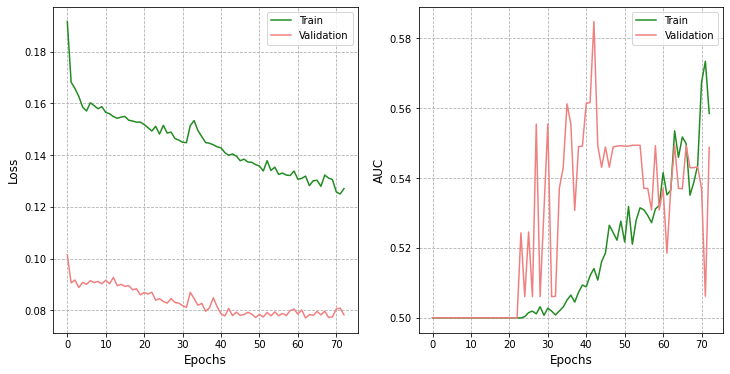

In [31]:
#Learning Curve for loss and auc

history_plot(loss, metrics)

In [32]:
#From above picture it's obvious regularization is needed.